# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

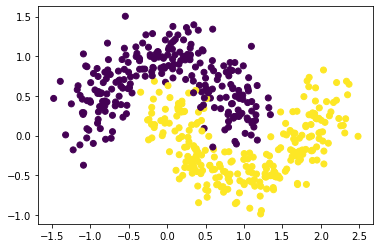

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression(random_state=42) # add some params
svm = SVC(kernel='linear', random_state=42) # here too

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def plot_decisions(X, y, estimator, estimator_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    plt.figure(figsize=(12, 8))
    plt.title("{}, accuracy = {}".format(estimator_name, acc))
    plot_decision_regions(X, y, estimator)
    
def get_accuracy(X, y, estimator, estimator_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

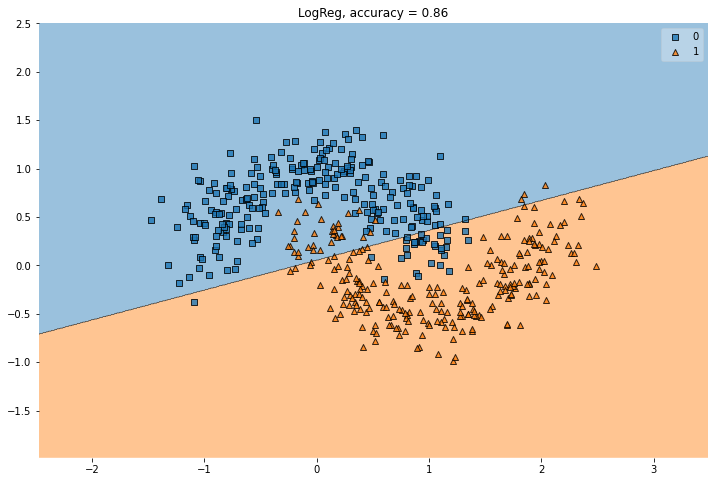

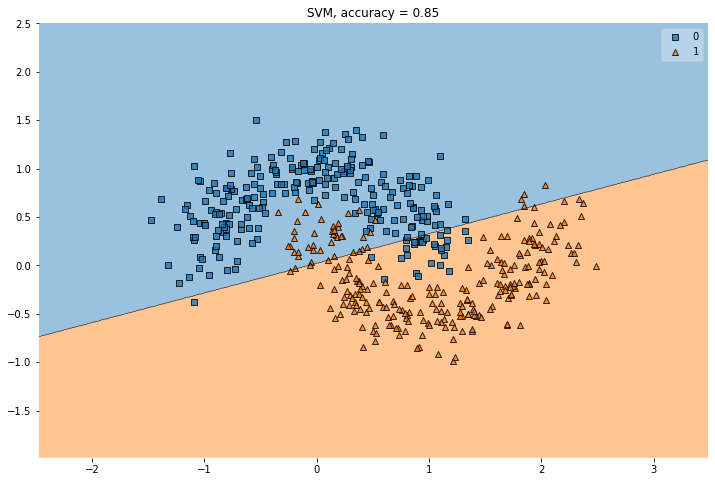

In [5]:
plot_decisions(moons_points, moons_labels, lr, 'LogReg')
plot_decisions(moons_points, moons_labels, svm, 'SVM')

Без дополнительных параметров, алгоритмы слабы, 86% достаточно хорошая точность, однако закономерности в данных они не уловили, выборки явно линейно не разделяются, необходимы дополнительные параметры, вомзожно, полиноминальное ядро или экспоненциальное.

## 1.2 Kernel tirck

![keep-calm](imgs/keep-calm.jpg)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

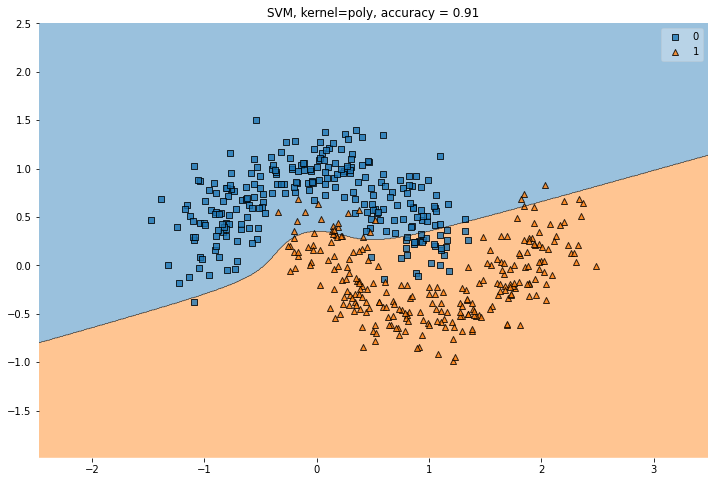

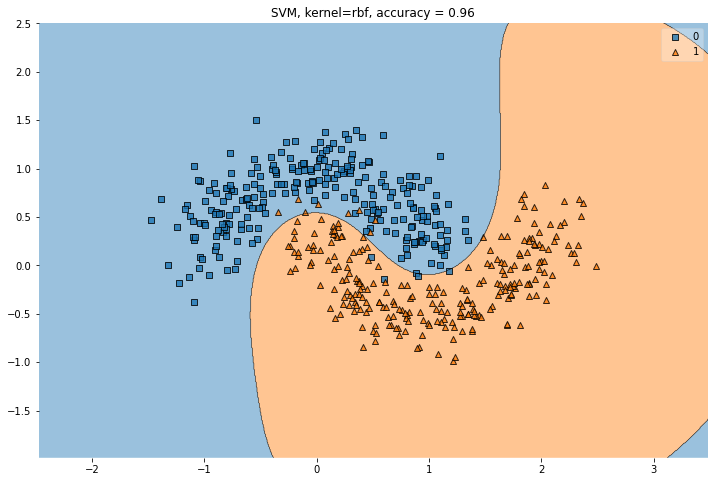

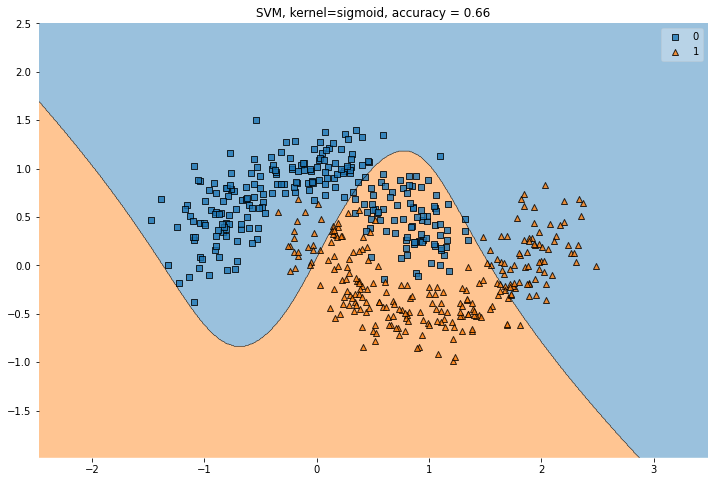

In [6]:
kernel_grid = ['poly', 'rbf', 'sigmoid']

for ker in kernel_grid:
    plot_decisions(moons_points, moons_labels, SVC(kernel=ker, random_state=42), 'SVM, kernel={}'.format(ker))

Сигмоиде не хорошо, она явно не подходит для этой выборки, а вот rbf имеет лучшие результаты, кажется, что правильно подобрав параметры можно еще улучшить алгоритм. Граница раздела зависит(даже описывается) ф-нй, указанной в kerenel, то есть это либо полином, либо сигмоида, либо $\exp(-\gamma\| x - x^{'}\|^2)$

Для полиномиального ядра, очеыидно, лучшей степенью будет 3, раздлеяющая поверхность сильно походит на полином третей степени.


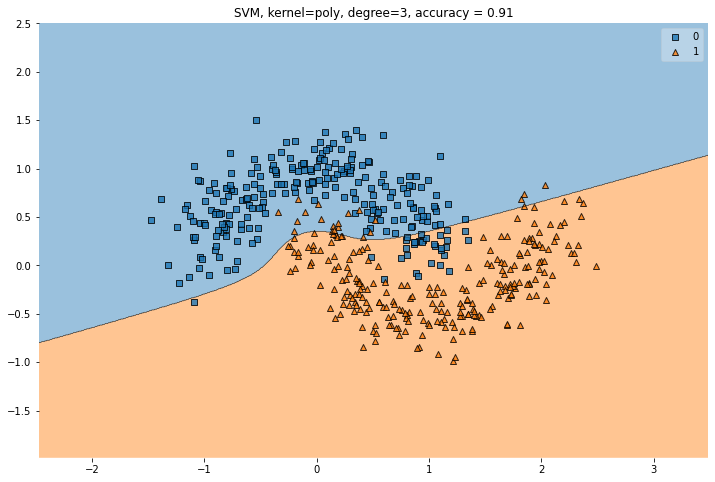

In [7]:
plot_decisions(moons_points, moons_labels, SVC(kernel='poly', degree=3, random_state=42), 'SVM, kernel=poly, degree=3')

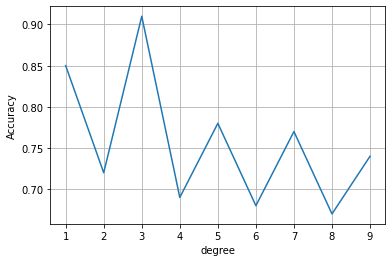

In [8]:
degree_grid=np.arange(1, 10)
    
ploy_acc = []
for deg in degree_grid:
    ploy_acc.append(get_accuracy(moons_points, moons_labels, SVC(kernel='poly', degree=deg, random_state=42), 'SVM, poly'))
    
plt.plot(degree_grid, ploy_acc)
plt.ylabel('Accuracy')
plt.xlabel('degree')
plt.grid()
plt.show()

Для радиального, построим по сетке

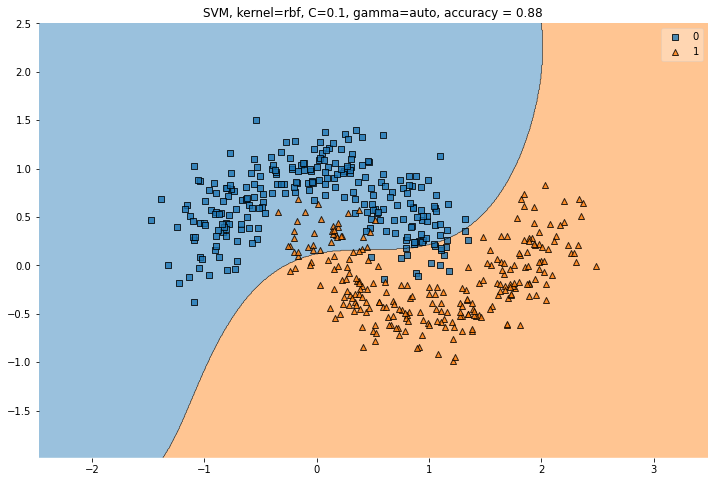

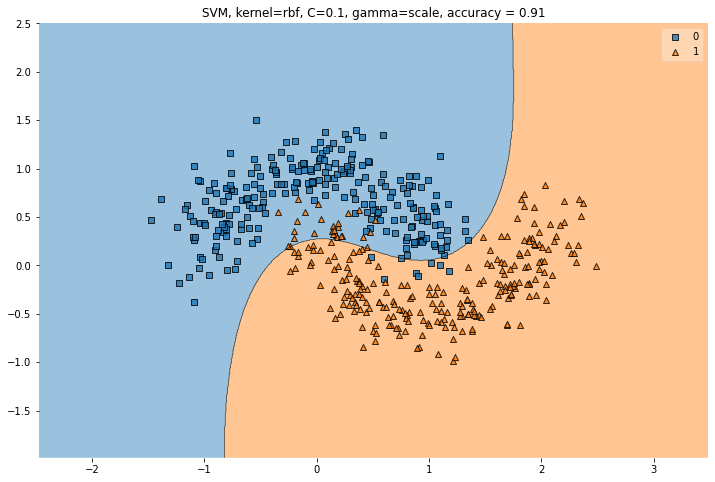

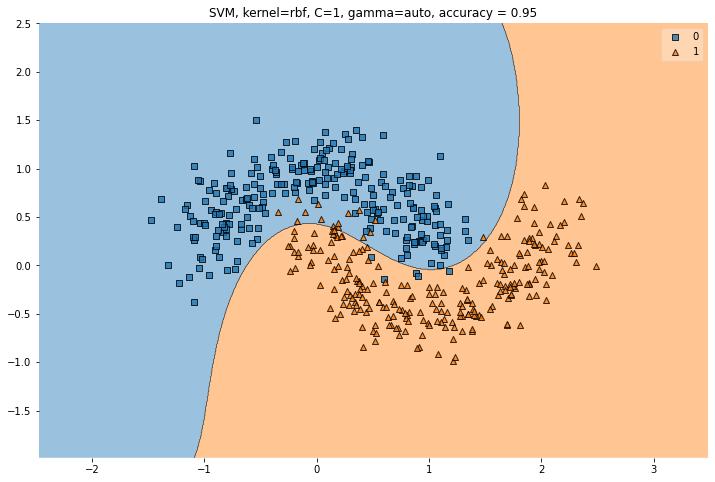

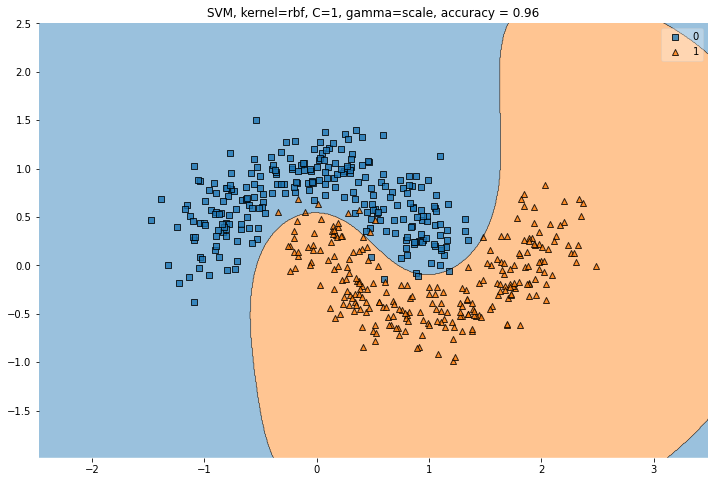

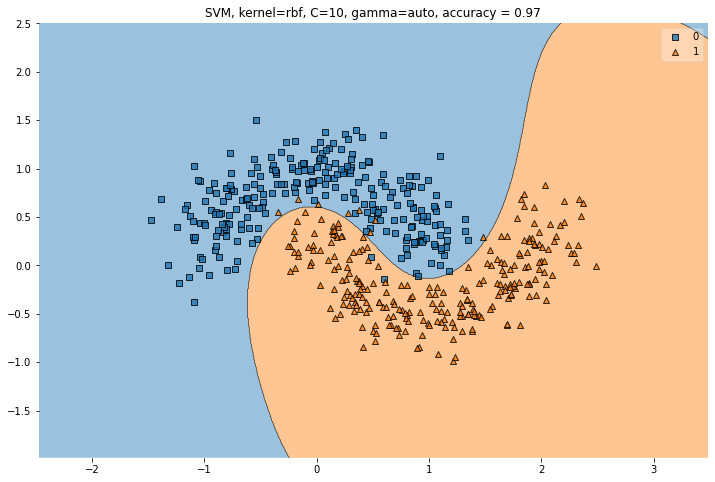

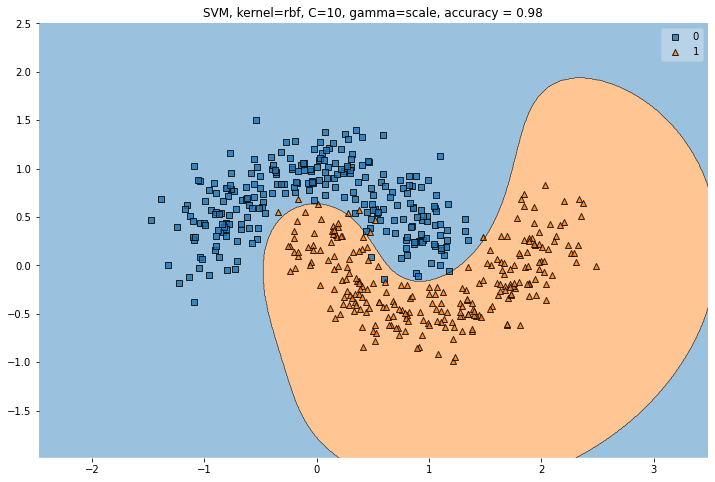

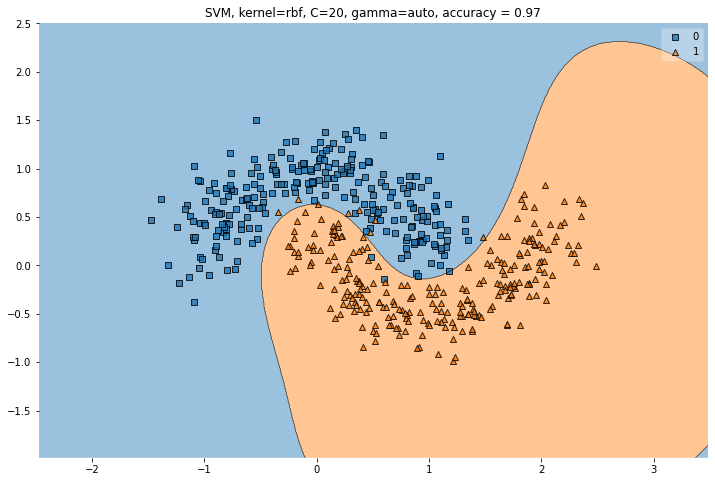

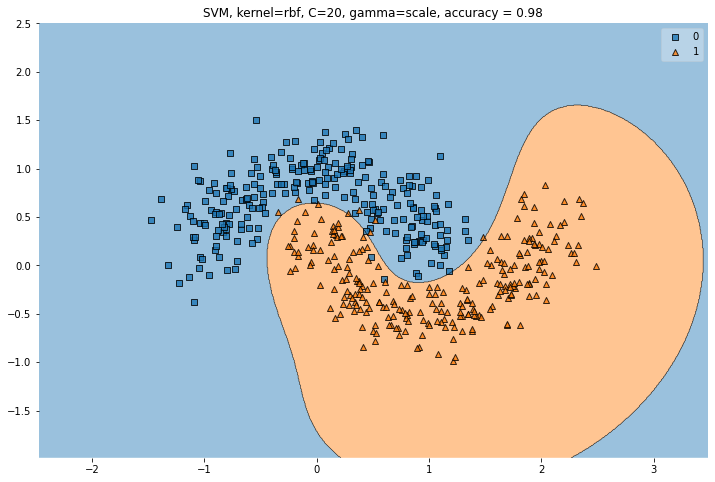

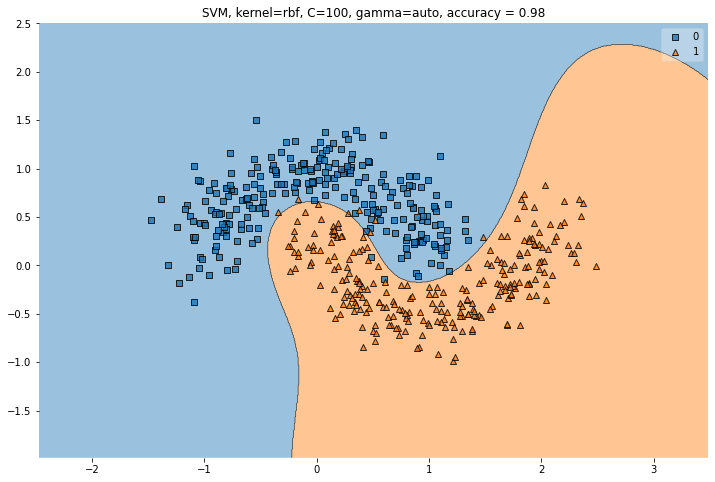

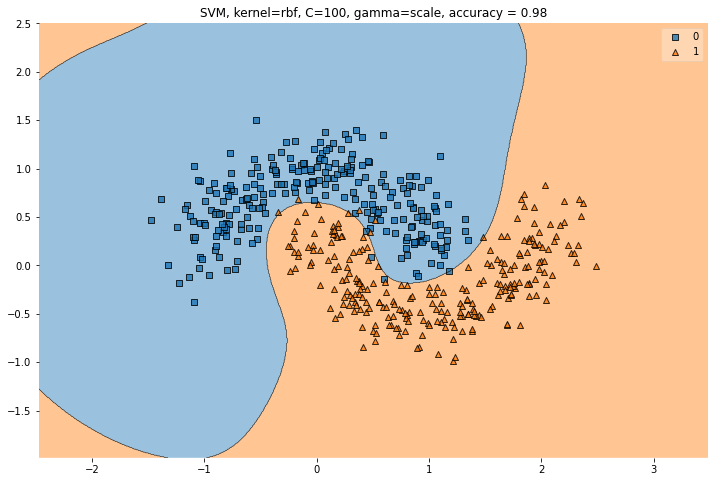

In [9]:
rbf_grid = {'C' : [0.1, 0.1, 1, 1, 10, 10, 20, 20, 100, 100],
           'gamma' : ['auto', 'scale', 'auto', 'scale', 'auto', 'scale', 'auto', 'scale', 'auto', 'scale']}


for i in range(len(rbf_grid['C'])):
    plot_decisions(moons_points, moons_labels, SVC(kernel='rbf', C=rbf_grid['C'][i], 
                                                   gamma=rbf_grid['gamma'][i], 
                                                   random_state=42), 
                   'SVM, kernel=rbf, C={}, gamma={}'.format(rbf_grid['C'][i], rbf_grid['gamma'][i]))
    

Предположения подтвердились, получилось обучить модель до 98% точности на тестовой выборке при C=20, это отличный результат, дальнейшее улучшение имеет мало смымсла, модель скорее переобучиться, так как некоторые точки явно в глубине чужого класса.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

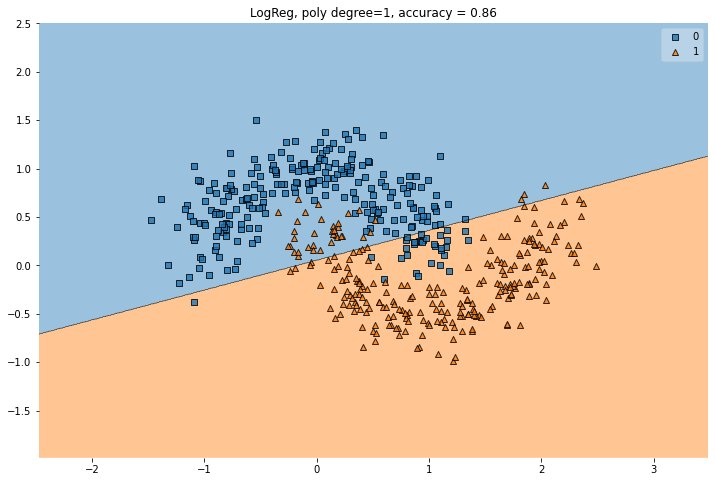

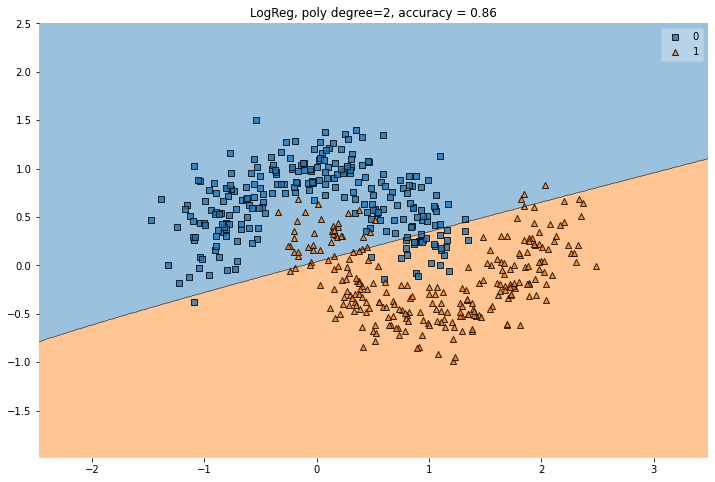

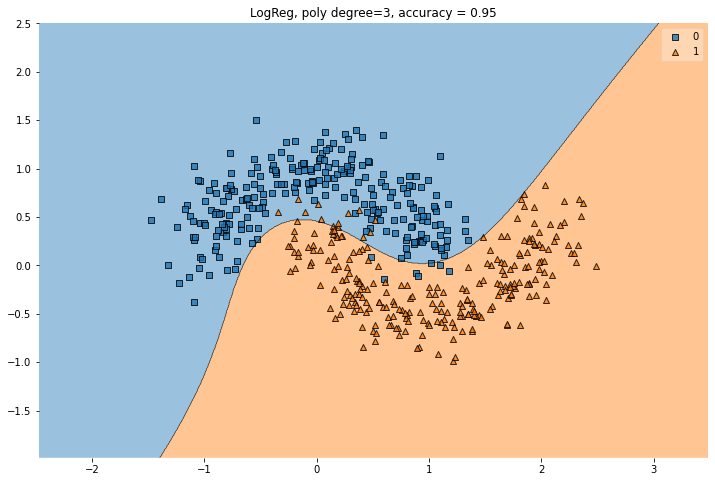

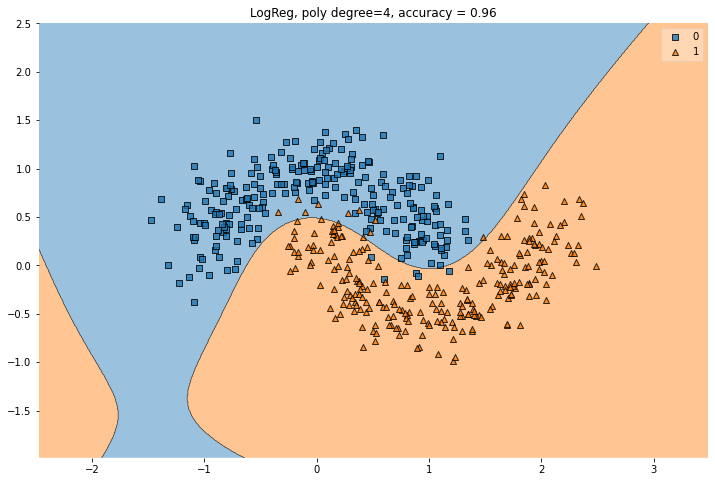

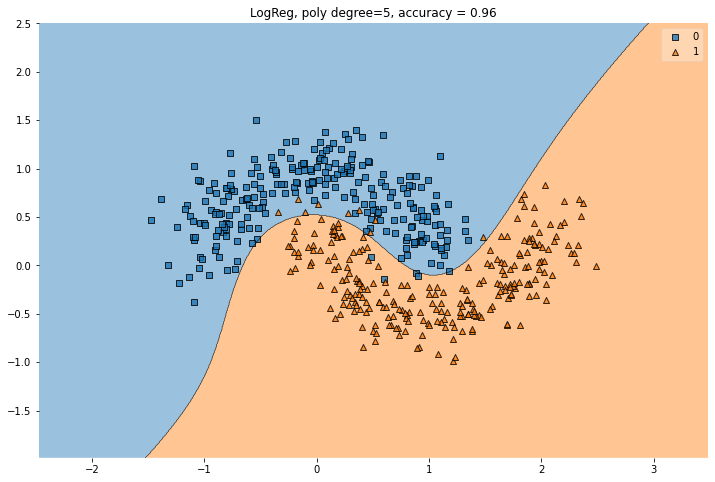

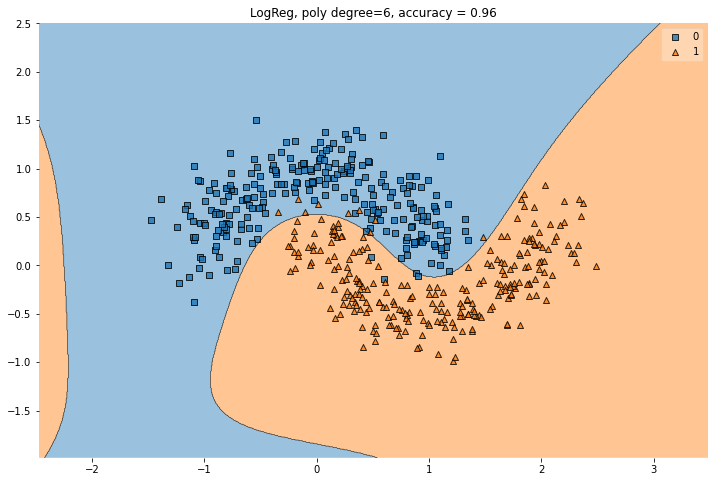

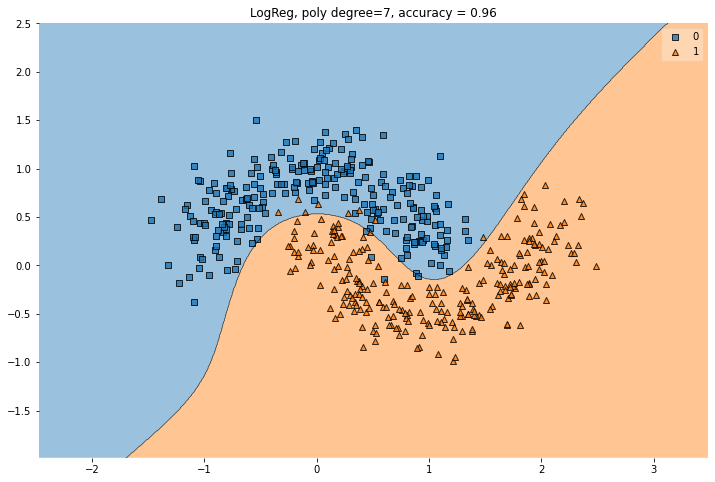

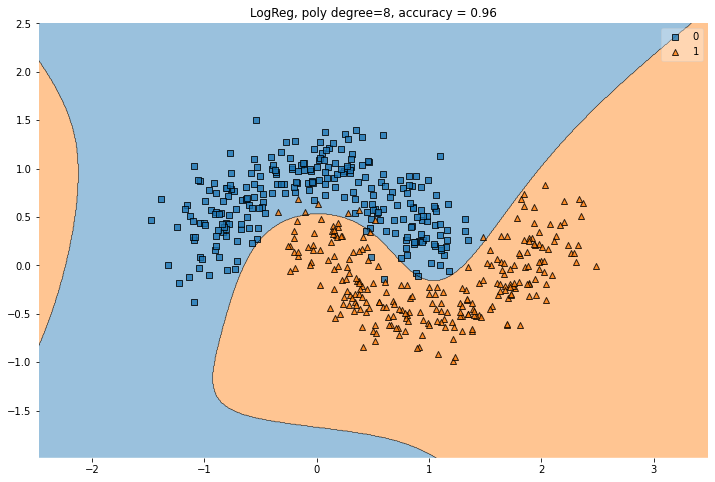

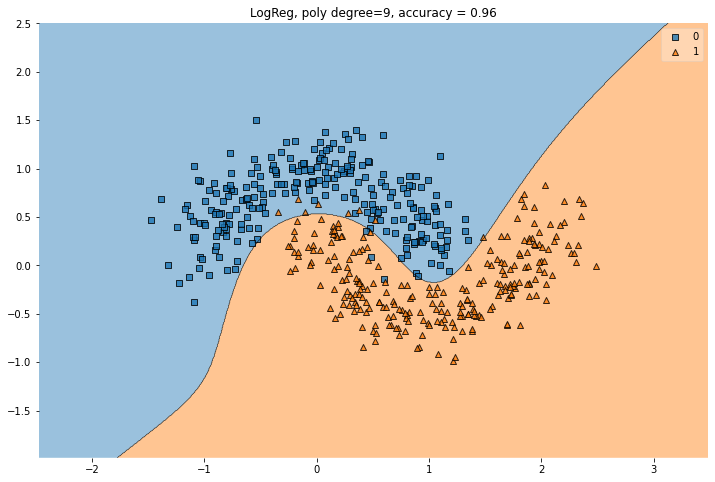

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

poly_degrees = np.arange(1, 10)

for deg in poly_degrees:
    plot_decisions(moons_points, moons_labels, 
                   Pipeline(steps=[('polyfeatures', PolynomialFeatures(deg)), 
                             ('logreg', LogisticRegression(random_state=42))]), 'LogReg, poly degree={}'.format(deg))
    

Точность логистической регрессии достигает 96 процентов на тестовой выборке(95 при степени 3) и больше не снижается, как и предполагалось, степень 3 или 4 оптимальна, в этом случае в осях исходных признаков разделяющая поверхность будет иметь вид полинома 3 степени. 

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

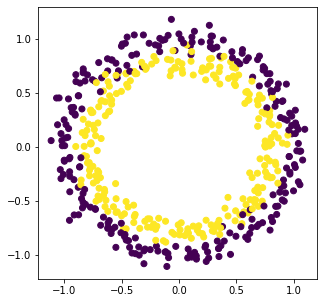

In [9]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

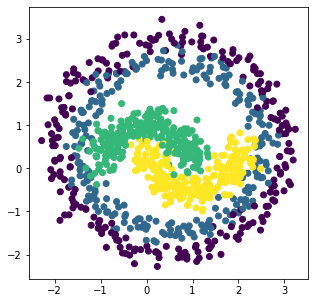

In [10]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

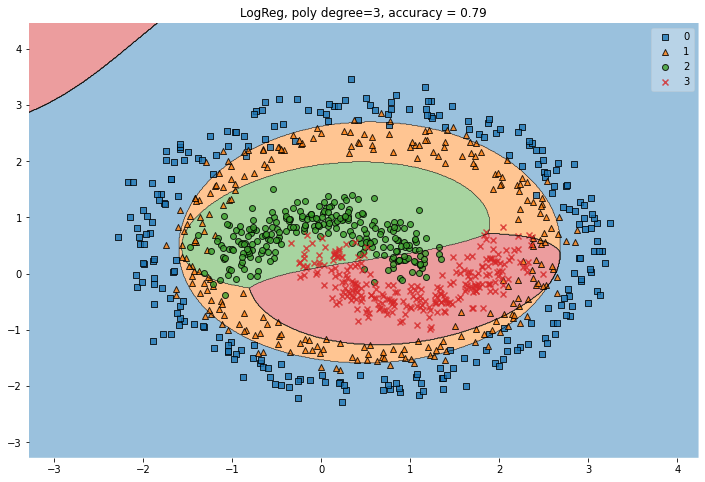

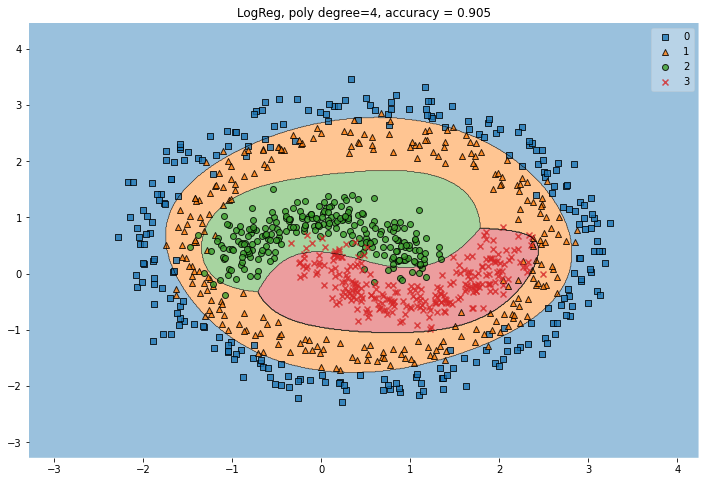

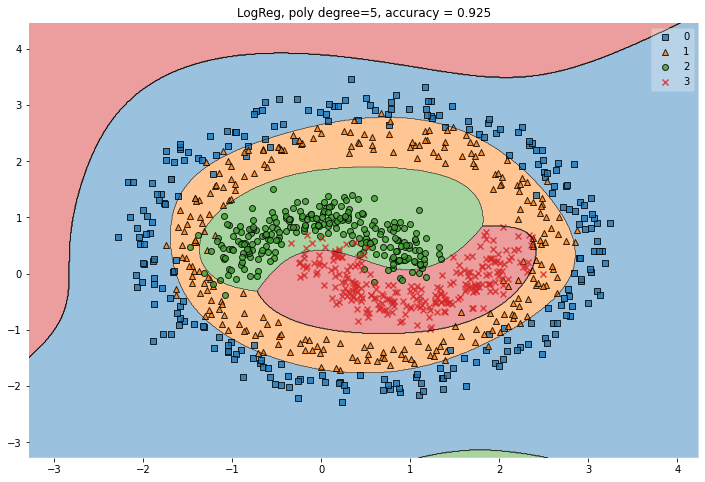

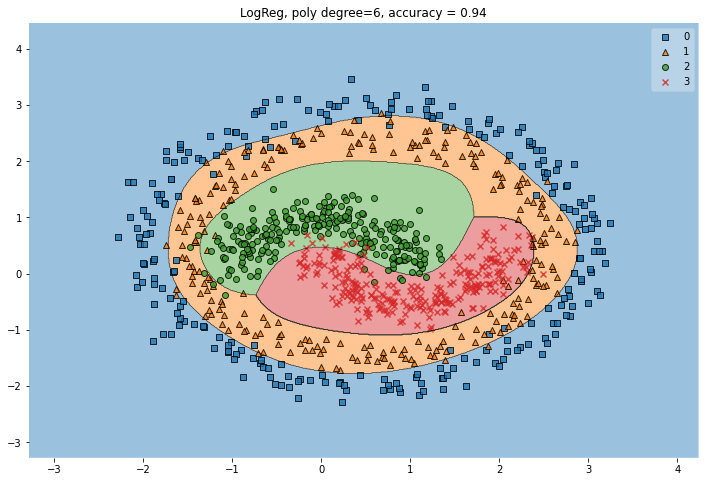

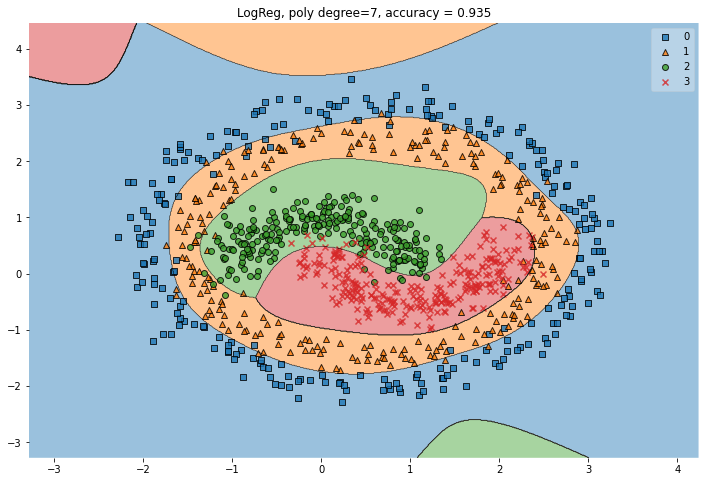

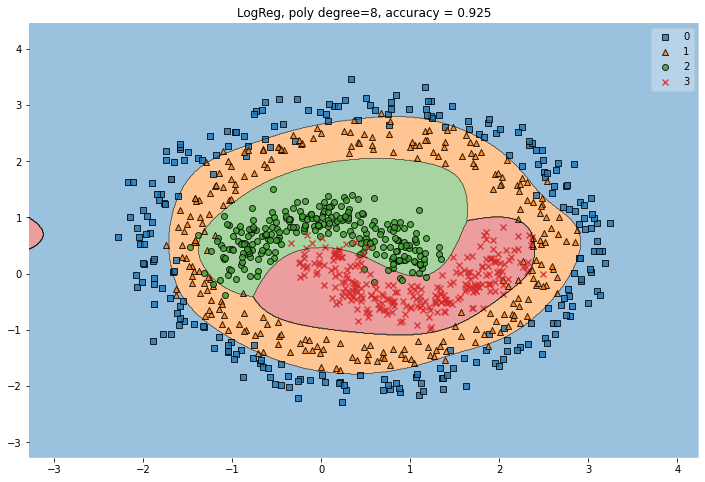

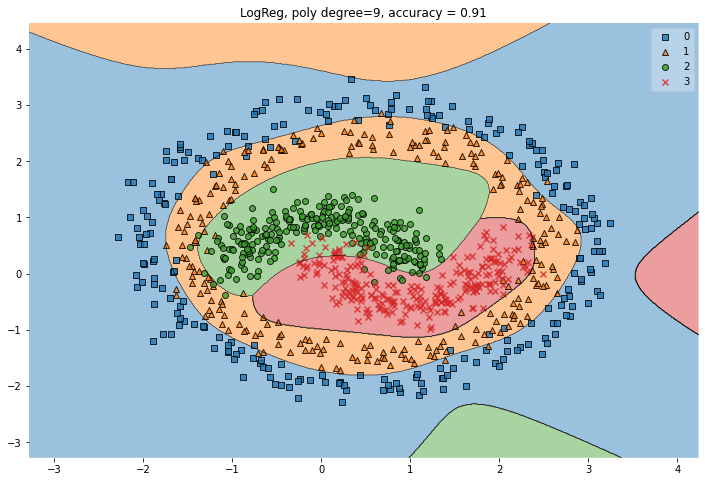

In [16]:
poly_degrees = np.arange(3, 10)

pypeline_create = lambda deg:  Pipeline(steps=[('polyfeatures', PolynomialFeatures(deg)), 
                             ('logreg', LogisticRegression(solver='liblinear', random_state=42))])

for deg in poly_degrees:
    plot_decisions(points, labels, pypeline_create(deg)
                   , 'LogReg, poly degree={}'.format(deg))    

Отлично, добились результата в 94% на тестовой выборке при добавлении poly features степени 6. Однако уже начинает ругаться библиотека, такое чрезмерное увеличение количества признаков заставляет сменить solver на liblinear.

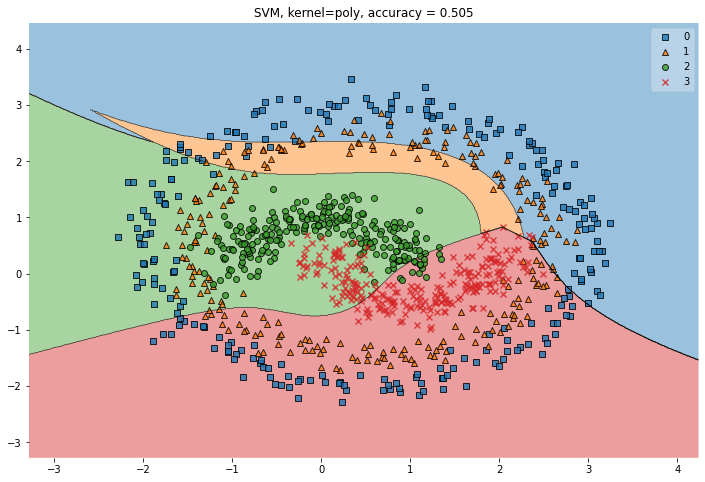

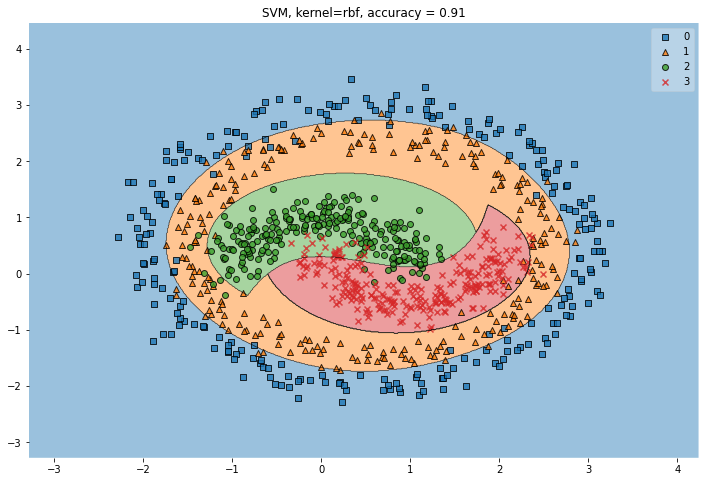

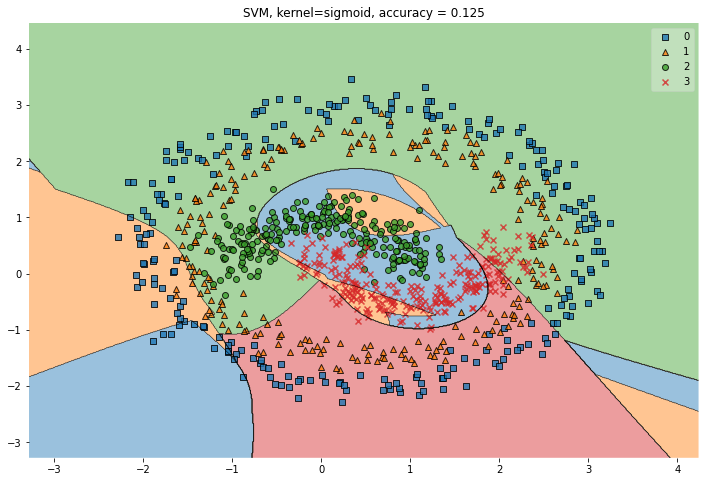

In [17]:
kernel_grid = ['poly', 'rbf', 'sigmoid']

for ker in kernel_grid:
    plot_decisions(points, labels, SVC(kernel=ker, random_state=42), 'SVM, kernel={}'.format(ker))

Как и в предудыщих заданиях, однозначно rbf.

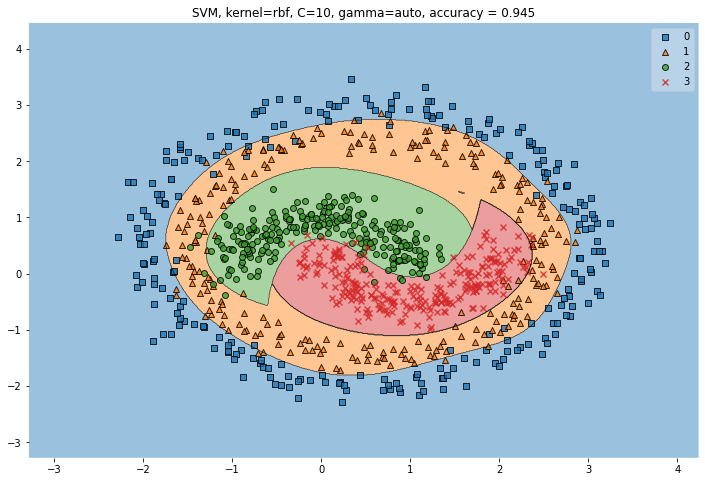

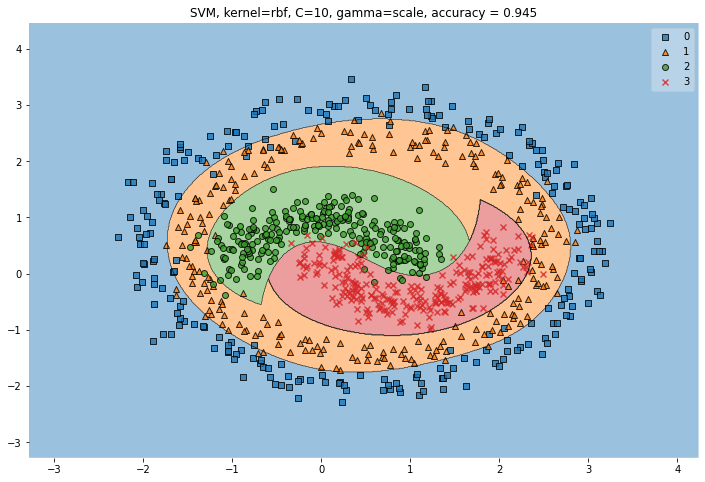

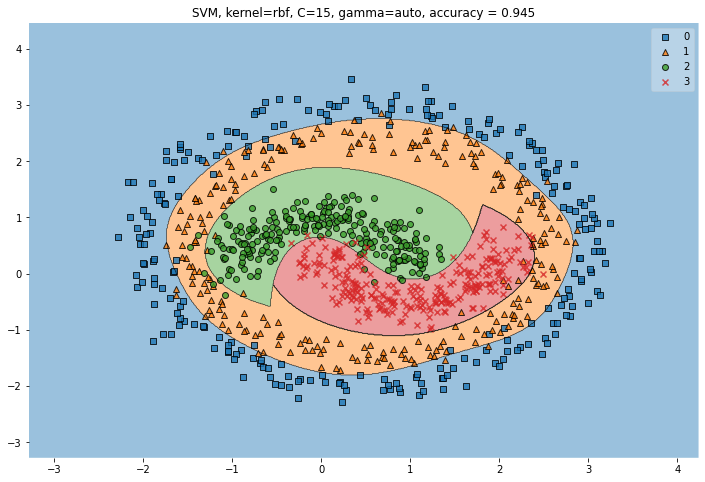

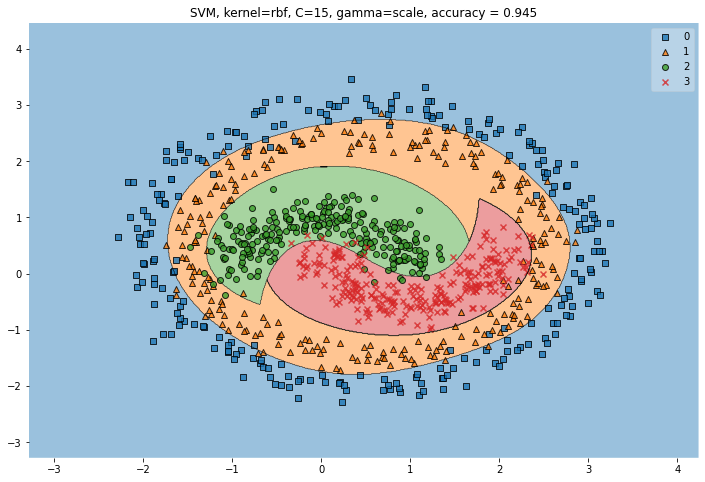

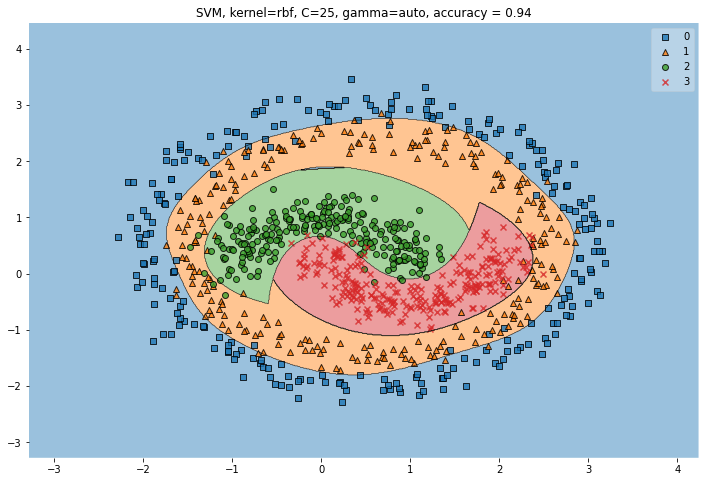

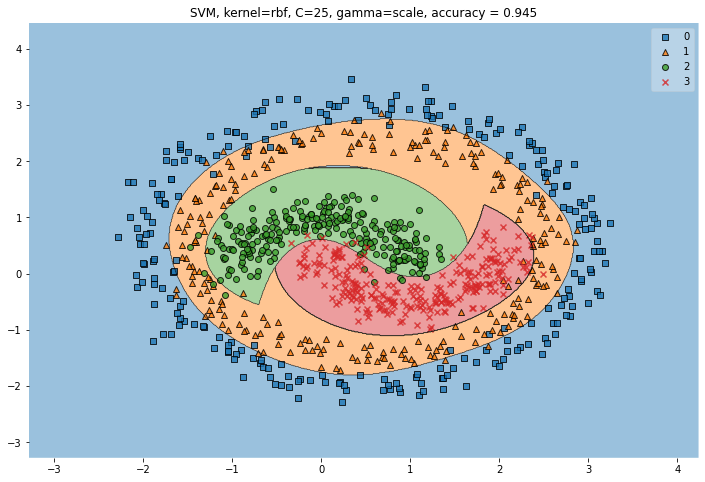

In [19]:
rbf_grid = {'C' : [10, 10, 15, 15, 25, 25],
           'gamma' : ['auto', 'scale', 'auto', 'scale', 'auto', 'scale']}


for i in range(len(rbf_grid['C'])):
    plot_decisions(points, labels, SVC(kernel='rbf', C=rbf_grid['C'][i], 
                                                   gamma=rbf_grid['gamma'][i], 
                                                   random_state=42), 
                   'SVM, kernel=rbf, C={}, gamma={}'.format(rbf_grid['C'][i], rbf_grid['gamma'][i]))
    

В итоге, с помощью svm и подбора параметра C, получаем точность в 94.5%, это классно. 

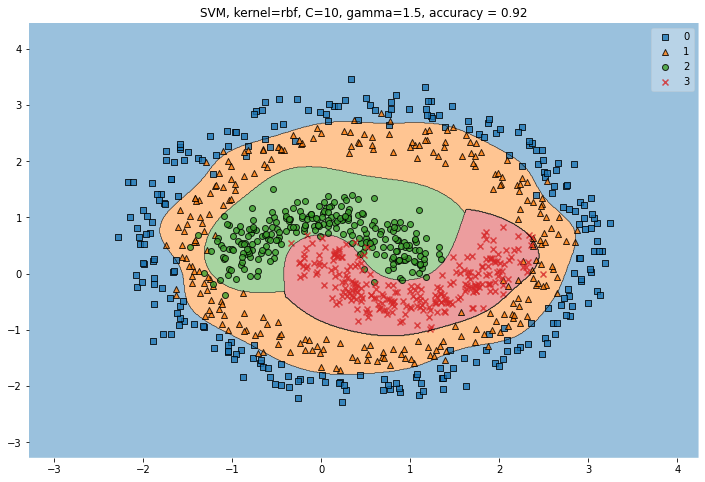

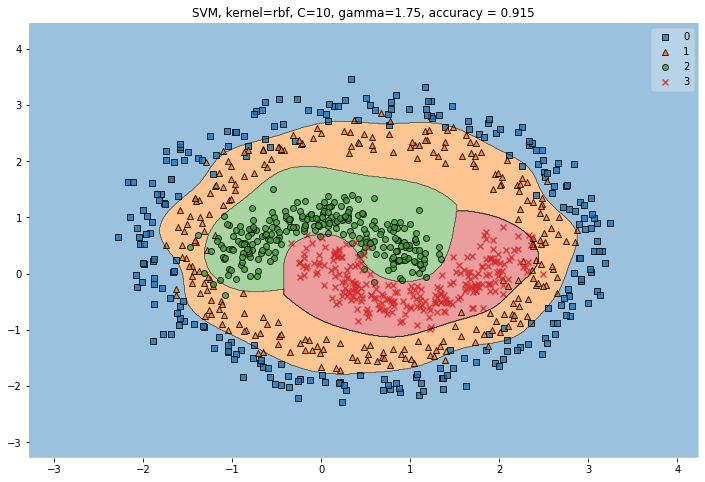

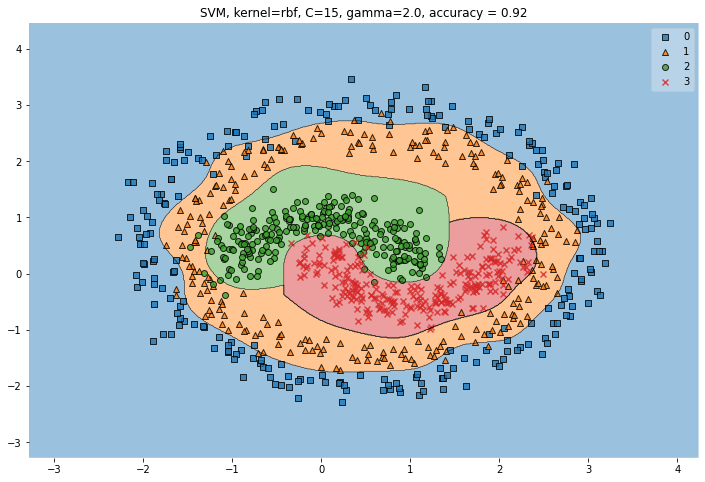

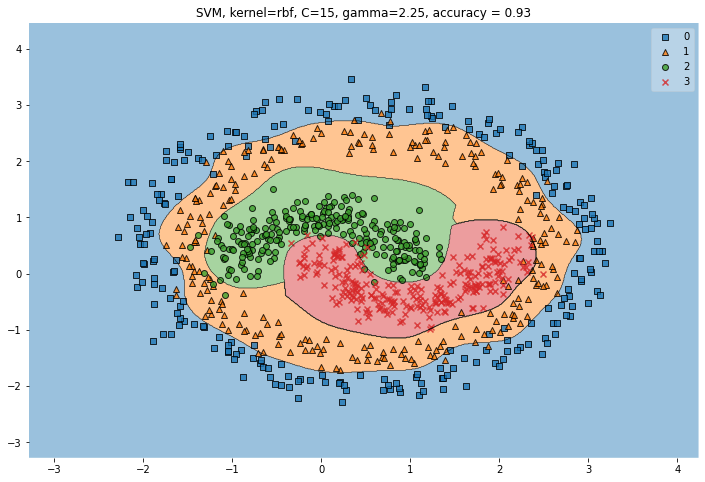

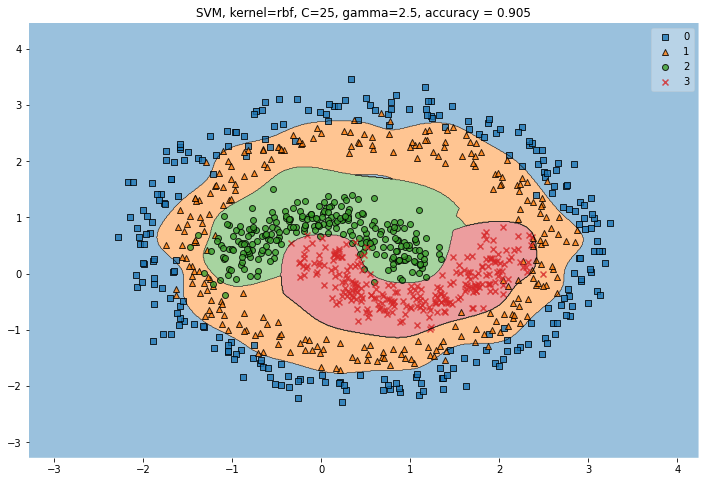

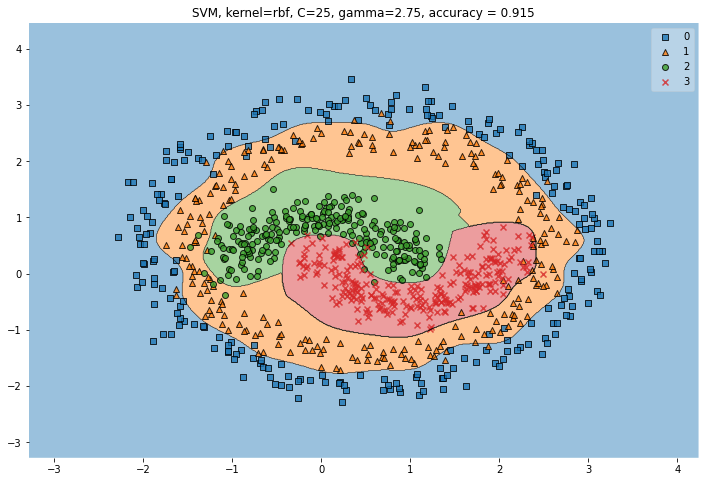

In [20]:
rbf_grid = {'C' : [10, 10, 15, 15, 25, 25],
           'gamma' : [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]}


for i in range(len(rbf_grid['C'])):
    plot_decisions(points, labels, SVC(kernel='rbf', C=rbf_grid['C'][i], 
                                                   gamma=rbf_grid['gamma'][i], 
                                                   random_state=42), 
                   'SVM, kernel=rbf, C={}, gamma={}'.format(rbf_grid['C'][i], rbf_grid['gamma'][i]))
    

Подобрать gamma точнее, чем это было сделано ранее, не удалось, текущий лучший результат около 94%. Для 4 label'ов это хороший классификартор. Лучший kernel - rbf.